# <u>Covid Detection with VGG-16<u>

I will be using the VGG16 model to detect Chest x-ray images that match with Chest x-ray images COVID-19.



List of classes of chest X-ray images given in the dataset -

Normal pneumonia , COVID-19 , Viral pneumonia chest , Lung Opacity (Non-COVID lung infection)



VGG16 is a convolutional neural network that is 16 layers deep. VGG16 has convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.




![alt text](image-1.png)

In [4]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt    
import pandas as pd
import seaborn as sns
%matplotlib inline
#deep learning libraries
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense , Dropout, Input, Flatten, BatchNormalization, Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation
from keras.optimizers import Adam, SGD
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# Explore Data Analysis

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)


100%|██████████| 778M/778M [01:18<00:00, 10.4MB/s] 

Extracting files...


Path to dataset files: /Users/namishrathy/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5


In [27]:
path_normal = "/Users/namishrathy/Desktop/pegasus/project_Covid_Detection_with_VGG-16/COVID-19_Radiography_Dataset/Normal/images"

print(os.path.exists(path_normal))

path_covid = "/Users/namishrathy/Desktop/pegasus/project_Covid_Detection_with_VGG-16/COVID-19_Radiography_Dataset/COVID/images"

print(os.path.exists(path_covid))


len_normal = len(os.listdir(path_normal))
len_covid = len(os.listdir(path_covid))

True
True


In [28]:
print(f"Normal Images: {len_normal}")
print(f"COVID Images: {len_covid}")


Normal Images: 10192
COVID Images: 3616


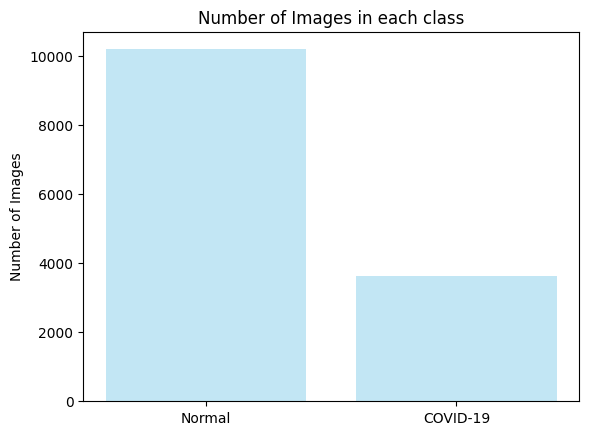

In [29]:
objects = ('Normal', 'COVID-19')
y_pos = np.arange(len(objects))
performance = [len_normal, len_covid]
plt.bar(y_pos, performance, align='center', alpha=0.5, color='skyblue')
plt.xticks(y_pos, objects)
plt.ylabel('Number of Images')
plt.title('Number of Images in each class')
plt.show()

Overview Chest X-ray images

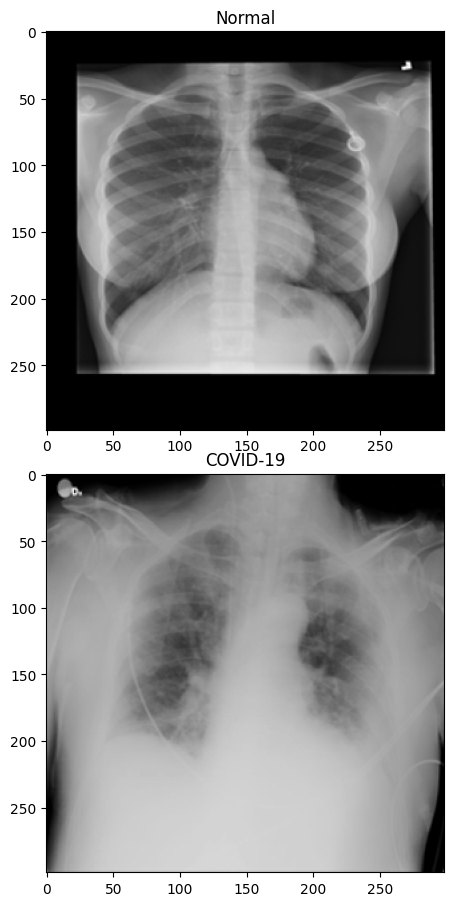

In [48]:
import glob

labels = ['Normal', 'COVID-19']

im1 = path_normal + '/Normal-1.png'
im2 = path_covid + '/COVID-1.png'
img = [im1, im2]

fig, ax = plt.subplots(2, figsize=(18, 9))
ax = ax.ravel()
plt.tight_layout()

for i in range(0,2):

    ax[i].imshow(plt.imread(img[i]), cmap='gray')
    ax[i].set_title(labels[i])

plt.show()   

Load Data

In [66]:
from PIL import Image, ImageOps

def resize_image(imgpath):
    img = np.array(
        ImageOps.grayscale(
            Image.open(imgpath).resize((64, 64), Image.Resampling.LANCZOS)
        )
    )
    return img


In [69]:
import os
x_ = list()
y = list()

for i in os.listdir(path_normal):
    try:
        imgpath = path_normal+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(0)
    except Exception as e:
         print(f"Error loading {imgpath}: {e}")
        
for i in os.listdir(path_covid):
    try:
        imgpath = path_covid+"/"+i
        img = resize_image(imgpath)
        x_.append(img)
        y.append(1)
    except Exception as e:
        print(f"Error loading {imgpath}: {e}")

x_ = np.array(x_)

In [70]:
print(f"Total images loaded: {len(x_)}")

Total images loaded: 13808


In [71]:
print("Normal samples:", os.listdir(path_normal)[:5])
print("COVID samples:", os.listdir(path_covid)[:5])


Normal samples: ['Normal-6196.png', 'Normal-7288.png', 'Normal-1821.png', 'Normal-4781.png', 'Normal-4959.png']
COVID samples: ['COVID-1.png', 'COVID-1175.png', 'COVID-1613.png', 'COVID-948.png', 'COVID-790.png']


# Split test, train, validation data

In [91]:
x_ = np.array(x_)              # shape: (samples, 64, 64)
x_ = np.expand_dims(x_, -1)    # shape: (samples, 64, 64, 1)
x_ = x_ / 255.0                # normalize to [0, 1]



In [92]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_,y,test_size = 0.2,random_state = 20)

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size = 0.15,random_state = 40)

In [93]:
from keras.utils import to_categorical

y = to_categorical(y,num_classes = 2)

classNames = ["normal","COVID_19"]
print(classNames)

['normal', 'COVID_19']


In [94]:
unique, counts = np.unique(y_train, return_counts=True)
uniqueVal, countsVal = np.unique(y_val, return_counts=True)

dict(zip(unique, counts))

{np.float64(0.0): np.int64(9389), np.float64(1.0): np.int64(9389)}

In [95]:
dict(zip(uniqueVal, countsVal))

{np.float64(0.0): np.int64(1657), np.float64(1.0): np.int64(1657)}

# Build VGG16 model

In [96]:
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [97]:
print(x_train.shape)  # Should be (samples, 64, 64, 1)

(9389, 64, 64, 1, 1)


In [98]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam, SGD

def build_vgg16_model():

    _input = Input(shape=(64,64,1))

    conv1 = Conv2D(filters=16 , kernel_size=(3,3) , activation='relu', padding='same')(_input)
    conv2 = Conv2D(filters=16 , kernel_size=(3,3) , activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = SeparableConv2D(filters=32 , kernel_size=(3,3) , activation='relu', padding='same')(pool1)
    conv4 = SeparableConv2D(filters=32 , kernel_size=(3,3) , activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv4)

    conv5 = SeparableConv2D(filters=64 , kernel_size=(3,3) , activation='relu', padding='same')(pool2)
    conv6 = SeparableConv2D(filters=64 , kernel_size=(3,3) , activation='relu', padding='same')(conv5)
    conv6 = BatchNormalization()(conv6)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv6)

    conv7 = SeparableConv2D(filters=128 , kernel_size=(3,3) , activation='relu', padding='same')(pool3)
    conv8 = SeparableConv2D(filters=128 , kernel_size=(3,3) , activation='relu', padding='same')(conv7)
    conv8 = BatchNormalization()(conv8)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv8)
    pool4 = Dropout(0.2)(pool4)

    conv9 = SeparableConv2D(filters=256 , kernel_size=(3,3) , activation='relu', padding='same')(pool4)
    conv10 = SeparableConv2D(filters=256 , kernel_size=(3,3) , activation='relu', padding='same')(conv9)
    conv10 = BatchNormalization()(conv10)
    pool5 = MaxPooling2D(pool_size=(2,2))(conv10)
    pool5 = Dropout(0.2)(pool5)

    flat = Flatten()(pool5)
    dense1 = Dense(512, activation='relu')(flat)
    dropout1 = Dropout(rate=0.7)(dense1)
    dense2 = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(rate=0.5)(dense2)
    output = Dense(2, activation='softmax')(dropout2)
    model = Model(inputs=_input, outputs=output)
    model.compile(optimizer= 'adam' , loss='binary_crossentropy', metrics=['accuracy'])


    return model
    

In [99]:
ModelFitRate = build_vgg16_model()
epochs = 20
ModelFitRate.summary()
history = ModelFitRate.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=epochs)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_32             │ (None, 32, 32, 32)     │           688 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_33             │ (None, 32, 32, 32)     │         1,344 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_34             │ (None, 16, 16, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_35             │ (None, 16, 16, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_36             │ (None, 8, 8, 128)      │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_37             │ (None, 8, 8, 128)      │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_38             │ (None, 4, 4, 256)      │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_39             │ (None, 4, 4, 256)      │        68,096 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 733,122 (2.80 MB)

 Trainable params: 732,162 (2.79 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 34s 105ms/step - accuracy: 0.7509 - loss: 0.5062 - val_accuracy: 0.2589 - val_loss: 1.0844
Epoch 2/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.8798 - loss: 0.2844 - val_accuracy: 0.2589 - val_loss: 1.5960
Epoch 3/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.9165 - loss: 0.2121 - val_accuracy: 0.7707 - val_loss: 0.5006
Epoch 4/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.9284 - loss: 0.1910 - val_accuracy: 0.9294 - val_loss: 0.1835
Epoch 5/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - accuracy: 0.9495 - loss: 0.1363 - val_accuracy: 0.7773 - val_loss: 0.8961
Epoch 6/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.9531 - loss: 0.1309 - val_accuracy: 0.8908 - val_loss: 0.2804
Epoch 7/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - accuracy: 0.9589 - loss: 0.1089 - val_accuracy: 0.9252 - val_loss: 0.1756
Epoch 8/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.9645 - loss: 0.0

[INFO] Loading details ...


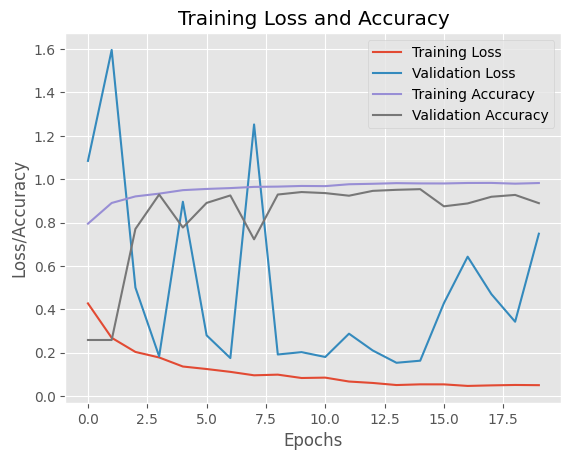

In [105]:

def show_report(history):

    print("[INFO] Loading details ...")

    N = epochs
    plt.figure()
    plt.style.use('ggplot')
    plt.plot(np.arange(0,N), history.history['loss'], label ='Training Loss')
    plt.plot(np.arange(0,N), history.history['val_loss'], label ='Validation Loss')
    plt.plot(np.arange(0,N), history.history['accuracy'], label ='Training Accuracy')
    plt.plot(np.arange(0,N), history.history['val_accuracy'], label ='Validation Accuracy')
    plt.title('Training Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.legend()
    plt.show()

show_report(history)

Hyper parameters

In [110]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
sd=[]
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1,1]

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        sd.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

epochs = 20
learning_rate = 0.001
decay_rate = 5e-6

model = build_vgg16_model()

adam = Adam(learning_rate=learning_rate,decay=decay_rate)

model.compile(loss='mean_squared_error',optimizer=adam,metrics=['mean_absolute_error','accuracy'])

def step_decay(losses):
    i = float(2*np.sqrt(np.array(history.losses[-1])))

    if i <0.6:
        lrate=0.001*1/(1+0.7*len(history.losses))
        decay_rate=2e-6
    else:
        lrate =0.0001
   
    return lrate
history=LossHistory()
lrate=LearningRateScheduler(step_decay)

myhistory = model.fit(x_train,y_train,validation_data=
                      (x_val, y_val),batch_size=64, 
                      epochs=epochs,callbacks=[history,lrate], verbose=1)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7193 - loss: 0.2200 - mean_absolute_error: 0.4479lr: 0.0001
147/147 ━━━━━━━━━━━━━━━━━━━━ 30s 183ms/step - accuracy: 0.7194 - loss: 0.2198 - mean_absolute_error: 0.4475 - val_accuracy: 0.7411 - val_loss: 0.2077 - val_mean_absolute_error: 0.4443 - learning_rate: 1.0000e-04
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7676 - loss: 0.1481 - mean_absolute_error: 0.2970lr: 0.0001
147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.7677 - loss: 0.1480 - mean_absolute_error: 0.2969 - val_accuracy: 0.7411 - val_loss: 0.2258 - val_mean_absolute_error: 0.4726 - learning_rate: 1.0000e-04
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8302 - loss: 0.1207 - mean_absolute_error: 0.2433lr: 0.0001
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.8303 - loss: 0.1206 - mean_absolute_error: 0.2432 - val_accuracy: 0.2589 - val_loss: 0.3748 - val_mean_absolute_error: 0.5897 - learni

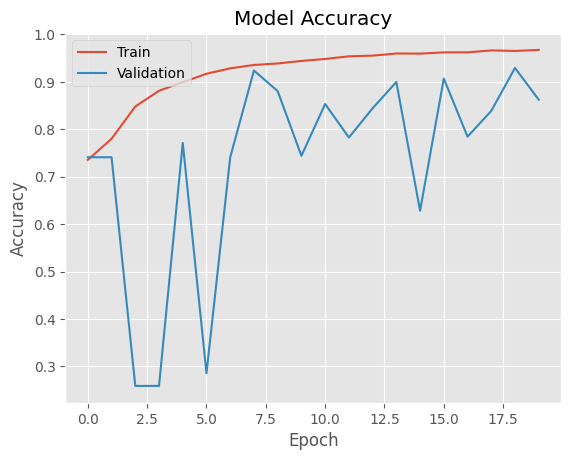

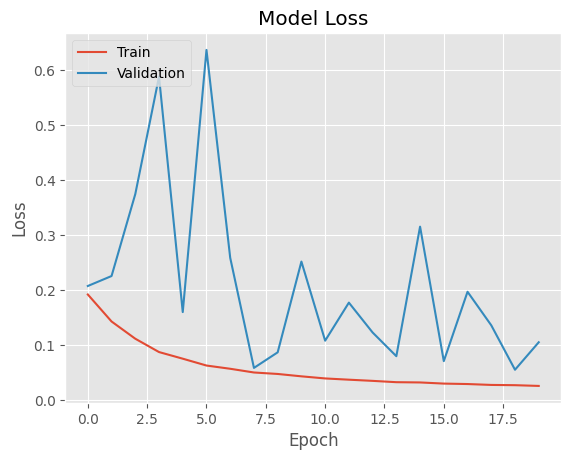

In [111]:
plt.plot(myhistory.history['accuracy'])
plt.plot(myhistory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

[INFO] Loading details ...


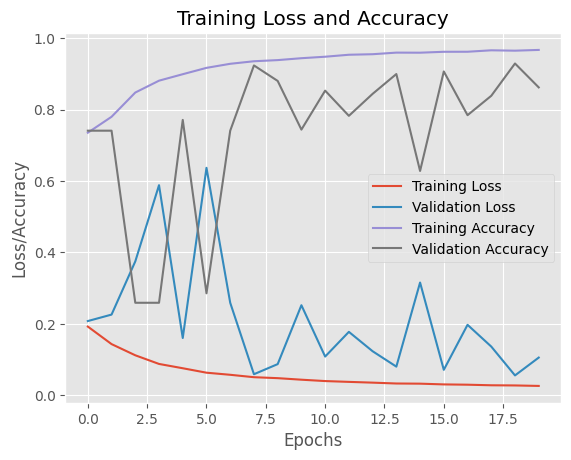

In [112]:
show_report(myhistory)

# Test and Evaluate Model

In [114]:
mypred = model.predict(x_test)

pred = np.argmax(mypred, axis=1)
print(pred)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
[0 0 0 ... 0 0 1]


In [115]:
evaluate = model.evaluate(x_test, y_test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8588 - loss: 0.1098 - mean_absolute_error: 0.1404


In [116]:
print("Accuracy: {:.2f}%".format(evaluate[2] * 100))  
print("Loss: {}".format(evaluate[0])) 

Accuracy: 86.28%
Loss: 0.10661917924880981


# Confusion matrix

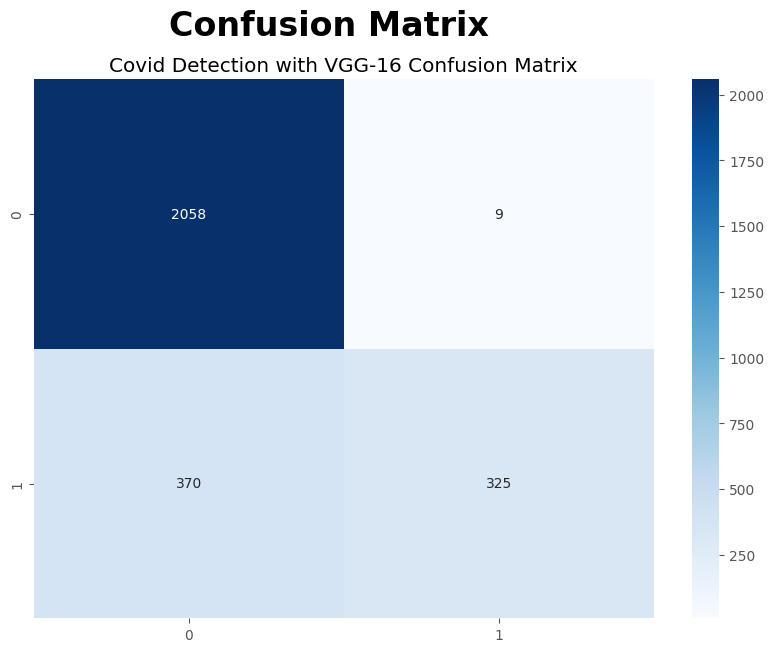

In [129]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

cm = confusion_matrix(y_test.argmax(axis=1), mypred.argmax(axis=1))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.suptitle('Confusion Matrix' , fontsize=24, fontweight='bold', x=0.42)
plt.title('Covid Detection with VGG-16 Confusion Matrix', x=0.5)
plt.show()

In [130]:
print('Accuracy Score: ' , accuracy_score(y_test.argmax(axis=1), mypred.argmax(axis=1)))
print('Report: ')
print(classification_report(y_test.argmax(axis=1), mypred.argmax(axis=1), target_names=classNames))

Accuracy Score:  0.8627805937726285
Report: 
              precision    recall  f1-score   support

      normal       0.85      1.00      0.92      2067
    COVID_19       0.97      0.47      0.63       695

    accuracy                           0.86      2762
   macro avg       0.91      0.73      0.77      2762
weighted avg       0.88      0.86      0.84      2762



# Thank You !